In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import glob
import os
import math

%matplotlib inline

In [16]:
def display_image_set(images, filename, cols_num=6):
    imgs_num = len(images)
    width_img = int(math.ceil(float(300) / float(cols_num)))
    rows_num = int(math.ceil(float(imgs_num) / float(cols_num)))
    height_init, width_init, channel = images[0].shape
    Kwidth = float(width_init) / float(width_img)
    height_img = int(height_init / Kwidth)
    result_shape = (rows_num * height_img, cols_num * width_img, channel)
    results_image = 255 * np.ones(shape=result_shape, dtype=np.uint8)
    
    for idx, img in enumerate(images):
        row = idx // cols_num
        col = idx - row * cols_num

        img_resized = cv2.resize(img, (width_img, height_img), interpolation = cv2.INTER_AREA)
        h, w, _ = img_resized.shape
        origin_y = row * h
        origin_x = col * w
        results_image[origin_y:origin_y+h, origin_x:origin_x+w, :] = img_resized

    cv2.imwrite('./preview/{}.jpg'.format(filename), cv2.cvtColor(results_image, cv2.COLOR_BGR2RGB))
    plt.rcParams["figure.figsize"] = (25, 25)
    plt.imshow(results_image.astype(np.uint8))
    plt.axis('off') 
    plt.show()

def region_of_interest(img, vertices):
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

def crop_roi(image, top_left, top_right, bottom_right, bottom_left):
    roi = [np.array([top_left, top_right, bottom_right, bottom_left], dtype=np.int32)]
    return region_of_interest(image, roi)

def crop_by_ref(img, ref_width, ref_height, ref_top_x, ref_top_y, ref_bot_x, ref_bot_y):
    width = img.shape[1]
    image_height = img.shape[0]
    middle_x = int(width / 2)
    image_offset_bottom_x = int(width * ref_bot_x / ref_width)
    image_offset_bottom_y = int(image_height * ref_bot_y / ref_height)
    image_offset_top_x = int(width * ref_top_x / ref_width)
    image_offset_top_y = int(image_height * ref_top_y / ref_height)
    top_left = [middle_x - image_offset_top_x, image_offset_top_y]
    top_right = [middle_x + image_offset_top_x, image_offset_top_y]
    bottom_right = [width - image_offset_bottom_x, image_offset_bottom_y]
    bottom_left = [image_offset_bottom_x, image_offset_bottom_y]

    return crop_roi(img, top_left, top_right, bottom_right, bottom_left)

def crop(image, bottom_offset = 0):
    ref_width = 960
    ref_height = 540
    ref_top_x = 50
    ref_top_y = 300
    ref_bottom_x = 70
    ref_bottom_y = 540 - bottom_offset

    return crop_by_ref(image, ref_width, ref_height, ref_top_x, ref_top_y, ref_bottom_x, ref_bottom_y)

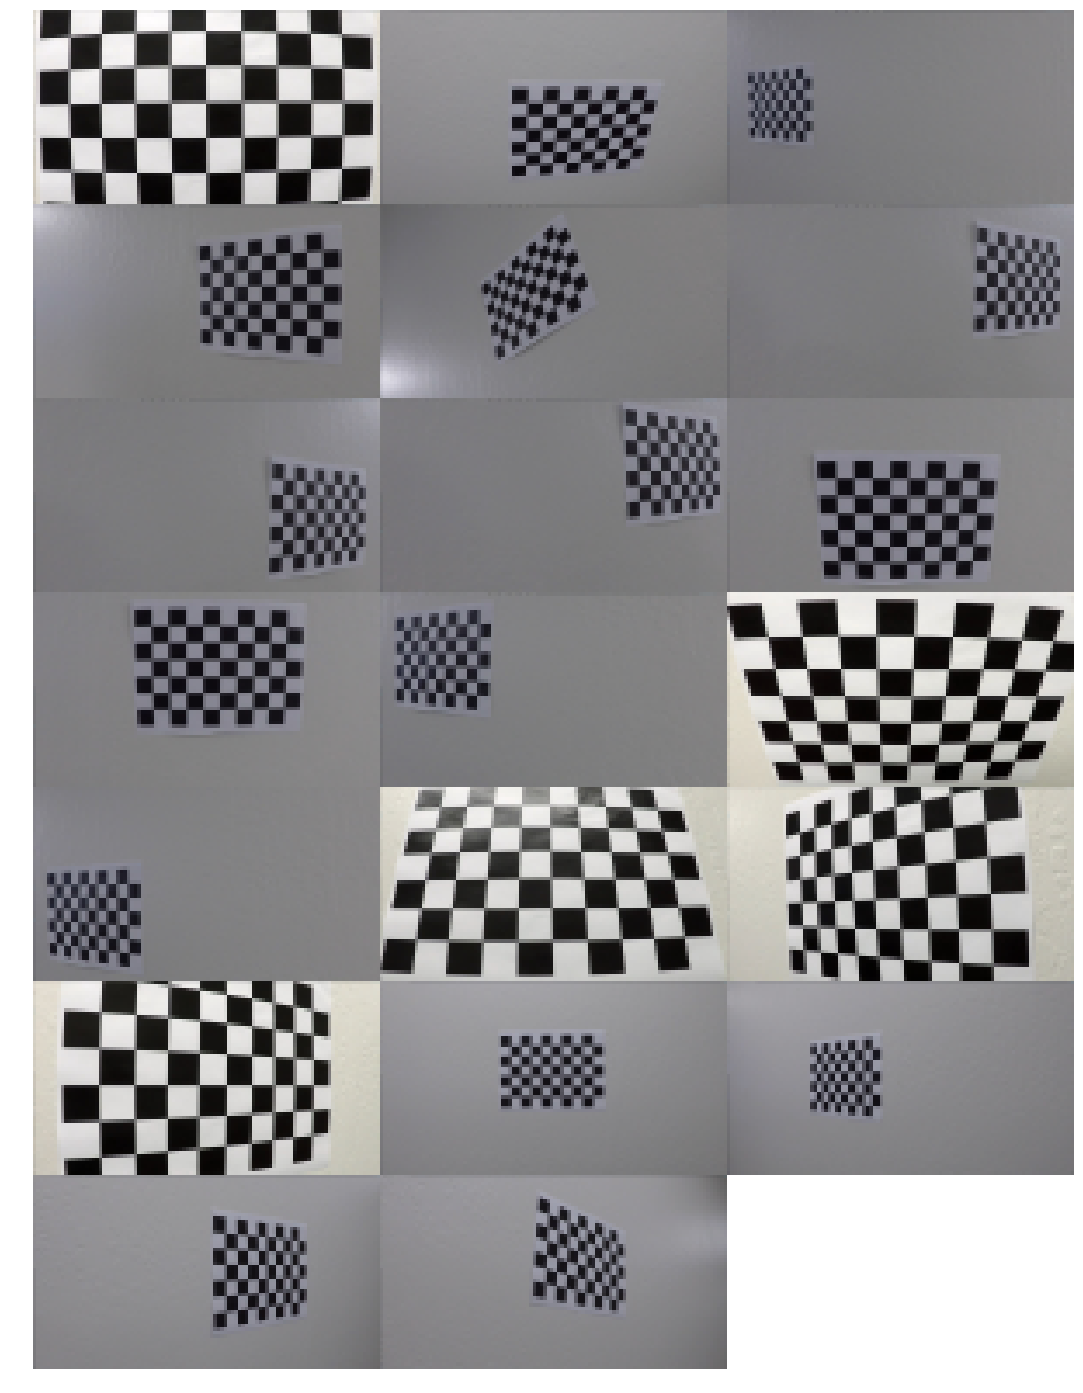

In [19]:
grids = []
files = glob.glob('./camera_cal/*.jpg')

for fname in files:
    grids.append(mpimg.imread(fname))
        
display_image_set(grids, 'calibrationGrids', cols_num=3)

Good images


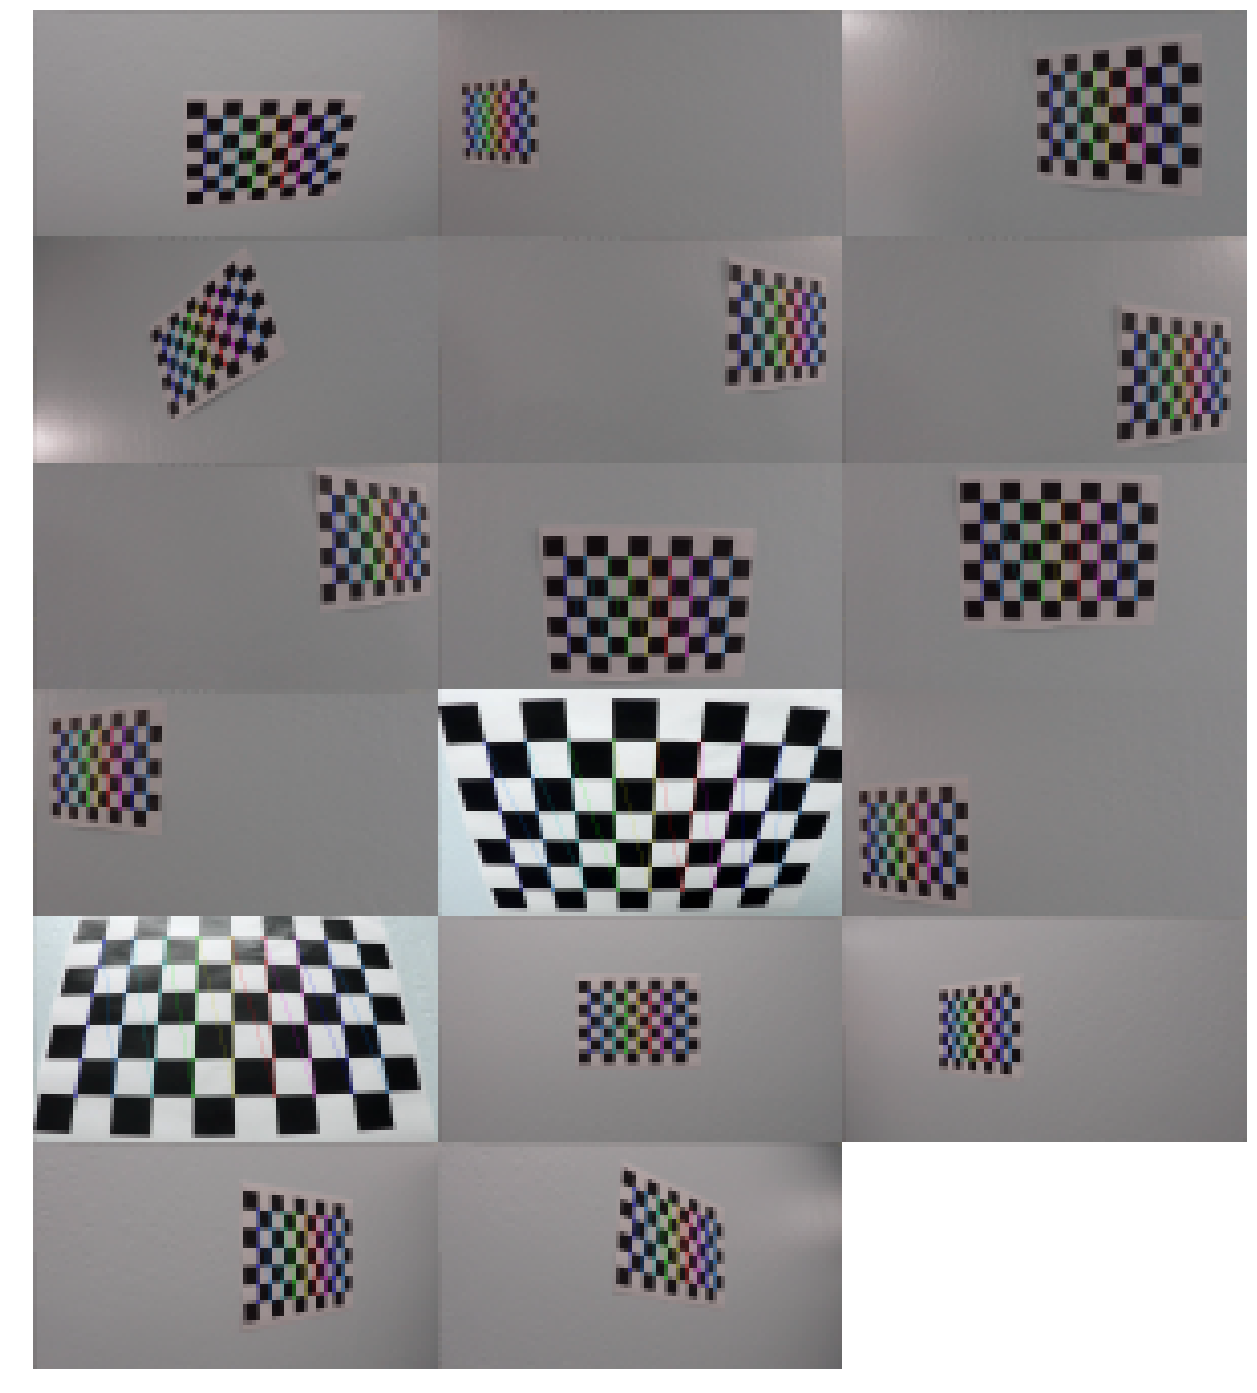


Bad images


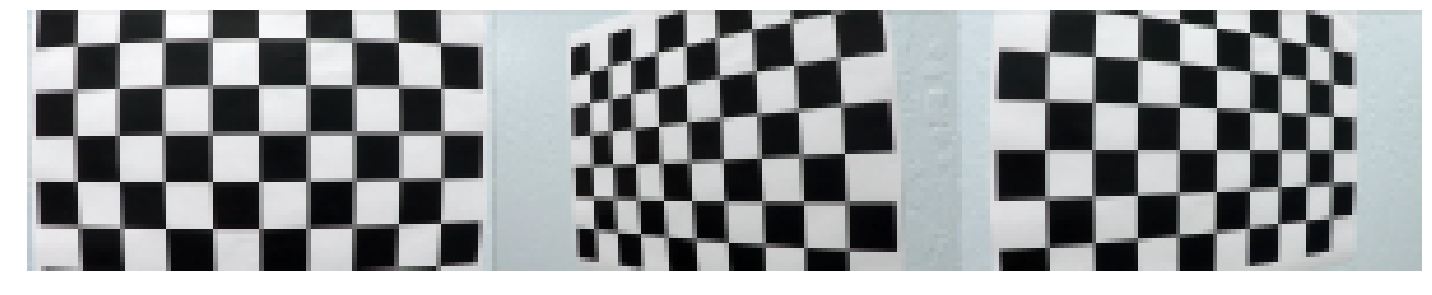

In [48]:
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(9,6,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:6,0:9].T.reshape(-1,2)
objp = objp * 57

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
files = glob.glob('./camera_cal/*.jpg')
corner_images = []
bad_images = []

for fname in files:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (6,9), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners_refined = cv2.cornerSubPix(gray, corners, (5,5), (-1,-1), criteria)
        img = cv2.drawChessboardCorners(img, (6,9), corners_refined, ret)
        
        objpoints.append(objp)
        imgpoints.append(corners_refined)
        corner_images.append(img)
    else:
        bad_images.append(img)

print("Good images")
display_image_set(corner_images, 'corners', cols_num=3)
print()
print("Bad images")
display_image_set(bad_images, 'corners', cols_num=3)

grids = corner_images + bad_images

total error: 0.10820530244890393


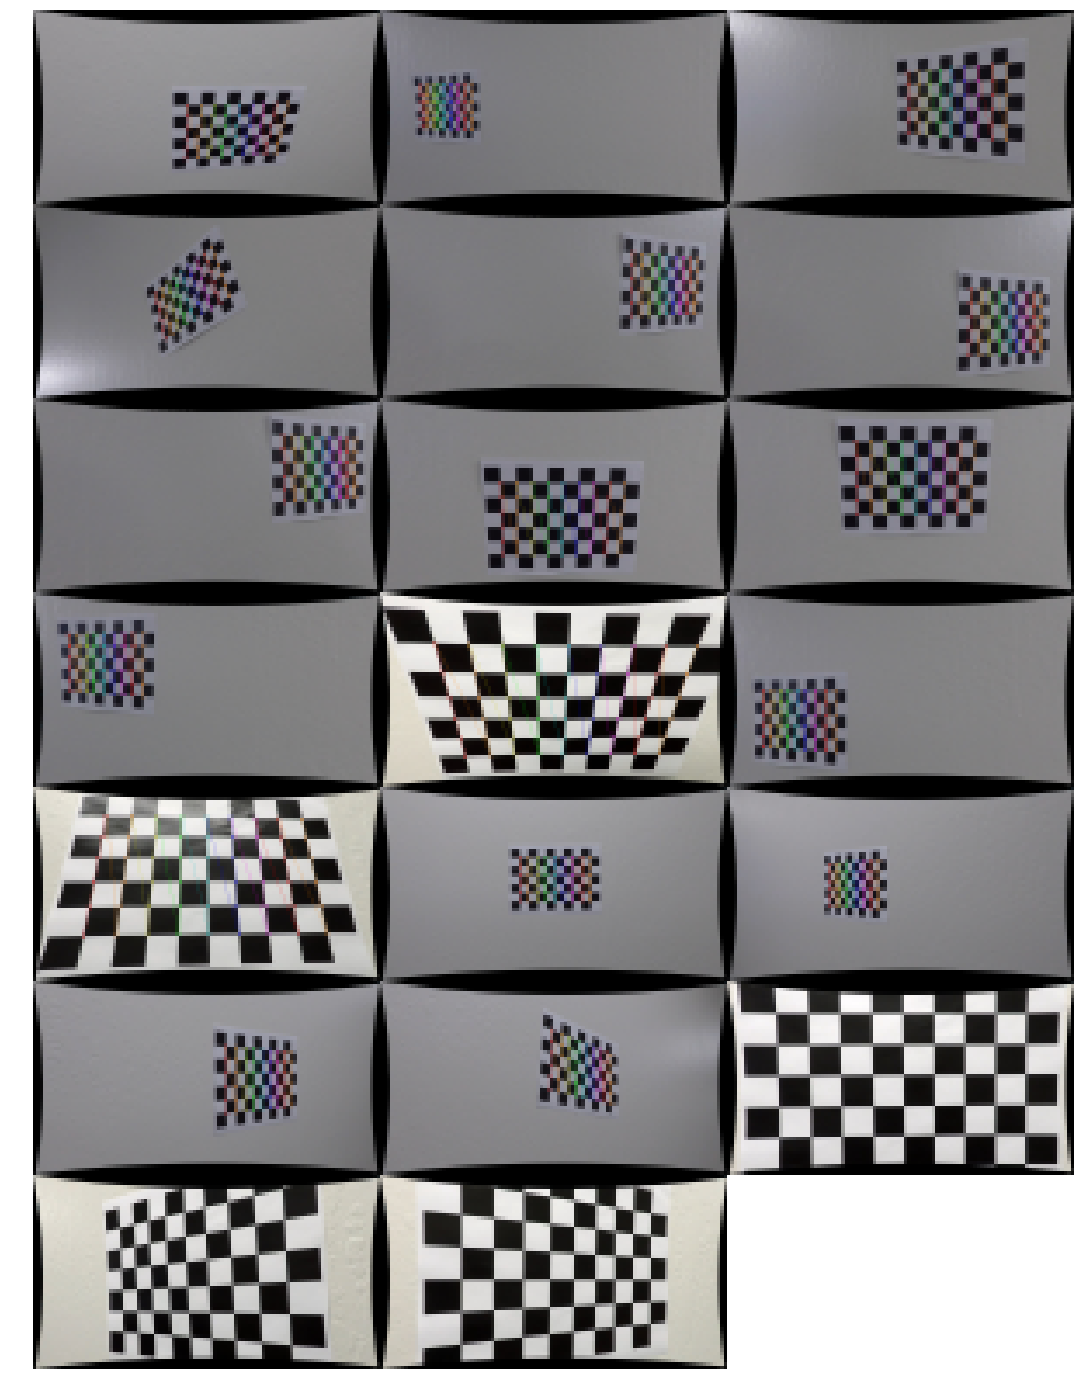

In [49]:
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
dst = cv2.undistort(img, mtx, dist, None, mtx)
h, w = gray.shape[:2]
newcameramtx, roi=cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)

# crop the image
x,y,w,h = roi
dst = dst[y:y+h, x:x+w]

mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i],imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error

print("total error:", mean_error/len(objpoints))

files = glob.glob('./camera_cal/*.jpg')
grids_undist = []

for image in grids:
    grid_undist = cv2.undistort(image, mtx, dist, None, newcameramtx)
    grid_undist = cv2.cvtColor(grid_undist, cv2.COLOR_BGR2RGB)
    grids_undist.append(grid_undist)

display_image_set(grids_undist, 'undistorted_grid', cols_num=3)

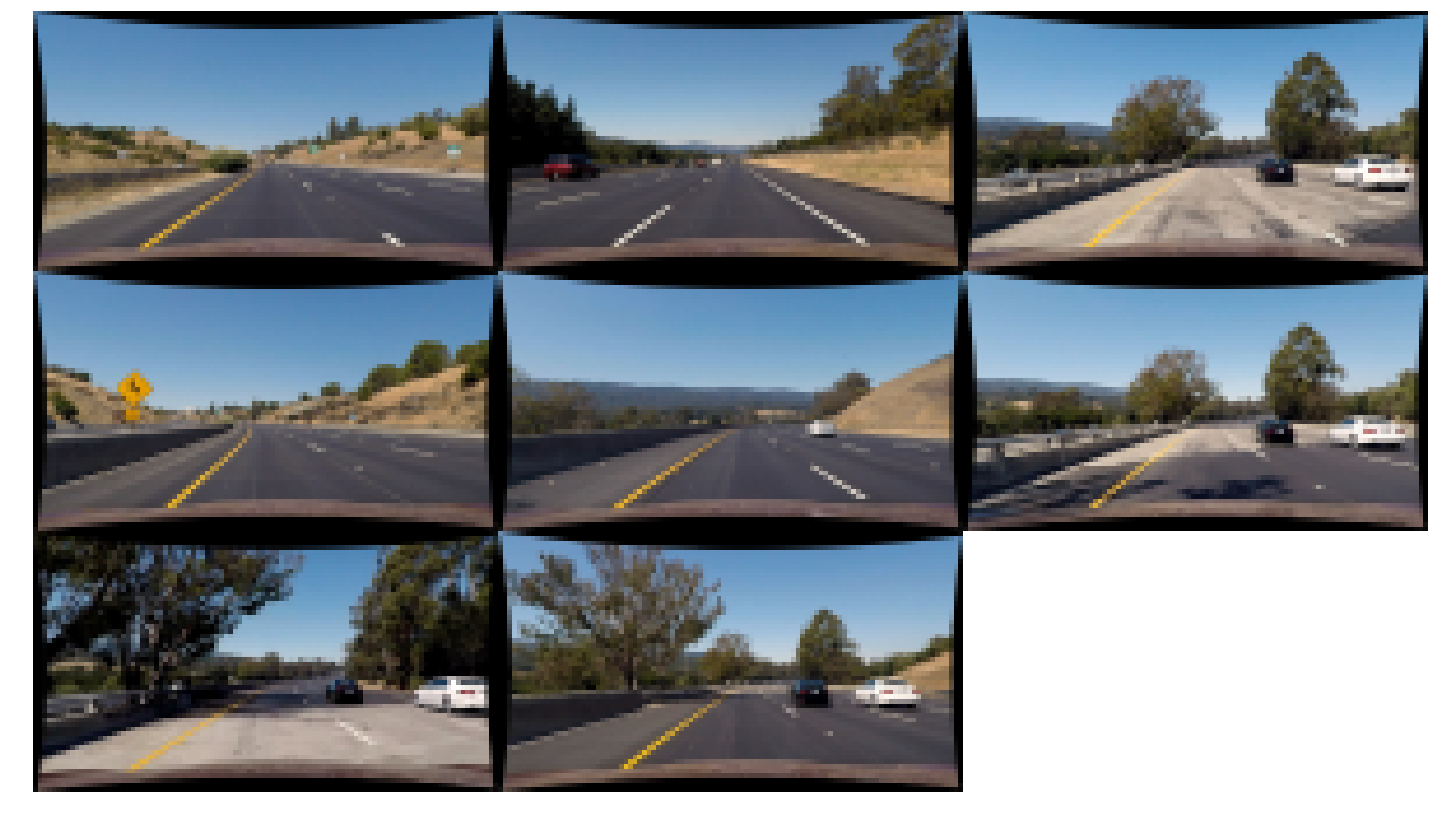

In [42]:
files = glob.glob('./test_images/*.jpg')
images_undist = []

for fname in files:
    img = cv2.imread(fname)
    img_undist = cv2.undistort(img, mtx, dist, None, newcameramtx)
    img_undist = cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB)
    images_undist.append(img_undist)
    
display_image_set(images_undist, 'undistorted', cols_num=3)